# Identifying potential Bot or Paid reviewers using Amazon customer review data using Network Analysis
**By: SLT11A**
* Abel Johua Cruzada
* James Gonzales

# Executive Summary

In [239]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

import networkx as nx
import networkx_abel as nxa

from matplotlib.gridspec import GridSpec

from networkx_abel.NodeSizeScaler import NodeSizeScaler
from networkx_abel.NetworkProperties import NetworkProperties
from networkx_abel.communities.LouvainMethod import LouvainMethod
from networkx_abel.communities.HierarchicalClustering import (
    HierarchicalClustering)

from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import euclidean
from collections import Counter
from itertools import chain

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from tqdm.notebook import tqdm
import warnings

In [2]:
aws_palette = ['#232f3e', '#e47911', '#007eb9', '#48a3c6', '#37475a']
sns.set_palette(palette=aws_palette)

# Introduction

The growth of online-selling platforms emphasized the power of influence of product reviews in shaping the perceptions about a product. People are swayed to buy a product when observed to have several positive ratings, while some are discouraged when the product ratings are negative. With this, the product frameworks could be helpful for customers to have confidence in buying a product. However, there are ways when the review framework can be abused and exploited. Bots and paid reviewers may sway a buyer to purchase something based the artificial or fake reviews.

This paper utilizes the Network Science concepts to Amazon's product review dataset to discover and analyze its network properties. A bipartite graph from two separate groups- customer_id and product_id will be used to form a graph. customer_ids are selected to be nodes, while the common product_id are the edges between nodes. Insights from generated network properties, clustering, community discoveries will be used to answer the paper's problem statement.


# Problem Statement

Given the product review dataset, what network properties and factors can be used to identify bot or fake reviewers?

# Objectives

* Create and describe the network formed from Amazon's products review dataset.
* Determine network properties.
* Detect communities from the given network.
* Identify bot and fake reviewers 

# Data Description

# Methodology

# Data Preprocessing

## Filtering

Only include data from 2015 onwards.

In [467]:
df = pd.read_csv('amazon_reviews_video_games.csv', index_col=0)

In [468]:
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,N,Y,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,N,Y,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,N,Y,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,N,Y,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,N,Y,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


Remove single value columns

In [469]:
df.drop(['marketplace', 'product_category'], axis=1, inplace=True)

## Text Preprocessing

Set stopwords and contractions

In [7]:
stop_words = stopwords.words('english')
CONTRACTIONS = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot",
    "'cause": "because", "could've": "could have", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not",
    "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
    "he'd": "he would", "he'll": "he will",
    "he's": "he is", "how'd": "how did",
    "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
    "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
    "I'll've": "I will have", "I'm": "I am",
    "I've": "I have", "i'd": "i would",
    "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
    "it'd've": "it would have", "it'll": "it will",
    "it'll've": "it will have", "it's": "it is",
    "let's": "let us", "ma'am": "madam", "mayn't": "may not",
    "might've": "might have", "mightn't": "might not",
    "mightn't've": "might not have", "must've": "must have",
    "mustn't": "must not", "mustn't've": "must not have",
    "needn't": "need not", "needn't've": "need not have",
    "o'clock": "of the clock", "oughtn't": "ought not",
    "oughtn't've": "ought not have", "shan't": "shall not",
    "sha'n't": "shall not", "shan't've": "shall not have",
    "she'd": "she would", "she'd've": "she would have",
    "she'll": "she will", "she'll've": "she will have", "she's": "she is",
    "should've": "should have", "shouldn't": "should not",
    "shouldn't've": "should not have", "so've": "so have",
    "so's": "so as",
    "this's": "this is", "that'd": "that would",
    "that'd've": "that would have", "that's": "that is",
    "there'd": "there would", "there'd've": "there would have",
    "there's": "there is", "here's": "here is", "they'd": "they would",
    "they'd've": "they would have", "they'll": "they will",
    "they'll've": "they will have", "they're": "they are",
    "they've": "they have", "to've": "to have", "wasn't": "was not",
    "we'd": "we would", "we'd've": "we would have", "we'll": "we will",
    "we'll've": "we will have", "we're": "we are", "we've": "we have",
    "weren't": "were not", "what'll": "what will",
    "what'll've": "what will have", "what're": "what are",
    "what's": "what is", "what've": "what have",
    "when's": "when is", "when've": "when have", "where'd": "where did",
    "where's": "where is", "where've": "where have", "who'll": "who will",
    "who'll've": "who will have", "who's": "who is", "who've": "who have",
    "why's": "why is", "why've": "why have", "will've": "will have",
    "won't": "will not", "won't've": "will not have",
    "would've": "would have", "wouldn't": "would not",
    "wouldn't've": "would not have", "y'all": "you all",
    "y'all'd": "you all would", "y'all'd've": "you all would have",
    "y'all're": "you all are", "y'all've": "you all have",
    "you'd": "you would", "you'd've": "you would have", "you'll": "you will",
    "you'll've": "you will have", "you're": "you are", "you've": "you have"}

abbv = {'ps':'playstation'}

In [8]:
def text_cleaner(text):
    """
    Cleans the text by removing dates and comments.
    i.e. text enclosed in brackets and parenthesis.
    Expand contractions and remove punctations.

    Parameters
    ----------
    text : str
        Text to clean.

    Return
    ------
    token : list of str
        Tokens extracted from text after cleaning.
    """
    month_pattern = (r'jan[\w]+ |feb[\w]+ |mar[\w]+ |apr[\w]+ |may |jun[\w]+ '
                     r'|jul[\w]+ |aug[\w]+ |sep[\w]+ |oct[\w]+ |nov[\w]+ '
                     r'|dec[\w]+ ')

    clean_text = text.lower()
    clean_text = re.sub(r'[\(\)\[\]\{\}]', ' ', clean_text)
    clean_text = re.sub(month_pattern, ' ', clean_text)
    clean_text = re.sub(r'"', '', clean_text)
    clean_text = re.sub(r"'s\b", ' ', clean_text)
    clean_text = re.sub(r'[^a-zA-Z]', ' ', clean_text)
    clean_text = re.sub(r'[\ ]+', ' ', clean_text)

    clean_text = [abbv[t] if t in abbv else t for t in clean_text.split(' ')]
    clean_text = ' '.join([CONTRACTIONS[t] if t in CONTRACTIONS else t
                           for t in clean_text])

    return simple_preprocess(clean_text, deacc=True, min_len=2)


def remove_words(words, remove_words=stop_words):
    """
    Remove remove words from the text.

    Parameters
    ----------
    words : list of str
        Words to remove remove_words.
    remove_words : set of str
        Words to remove.

    Returns
    -------
    text : str
        Texts without stop words
    """
    return [word for word in words if not word in remove_words]

# EDA

In [9]:
print(('Overall there are {} different products and variations out of {} '
       'reviews in our dataset.')
      .format(df.product_id.nunique(), df.shape[0]))

Overall there are 32693 different products and variations out of 330966 reviews in our dataset.


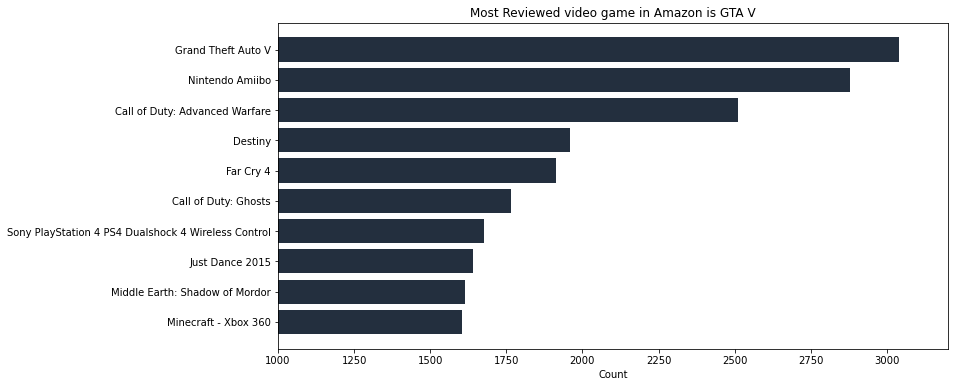

In [10]:
top10_prod = df.product_title.value_counts().head(10)
top10_prod.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh(top10_prod.index, top10_prod)
plt.title('Most Reviewed video game in Amazon is GTA V')
plt.xlabel('Count')
plt.xlim((1000, 3200))
plt.show()

The most extremely popular videogame in our dataset is GTA V and Nintendo Amiibo. With numerous reviews, it can gain the trust of potential customers based on the reviews in search of reliable opinion. Hence, it can further lead to increase in sales for the particular product.

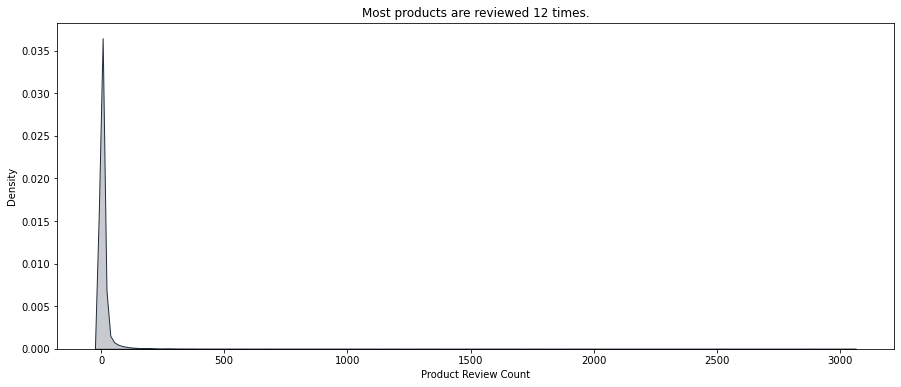

In [11]:
prod_counts = df.product_title.value_counts()
plt.figure(figsize=(15, 6))
sns.kdeplot(prod_counts, shade=True)
plt.title(f'Most products are reviewed {int(prod_counts.mean())} times.')
plt.xlabel('Product Review Count')
plt.show()

The plot above shows that rightly skewed distribution of product review counts. Some products are extremely popular reaching a scale of a thousand reviews, showcasing its reliability (because of many buyers/reviewers). In comparison, most of the products in the dataset are only reviewed around 12 times.

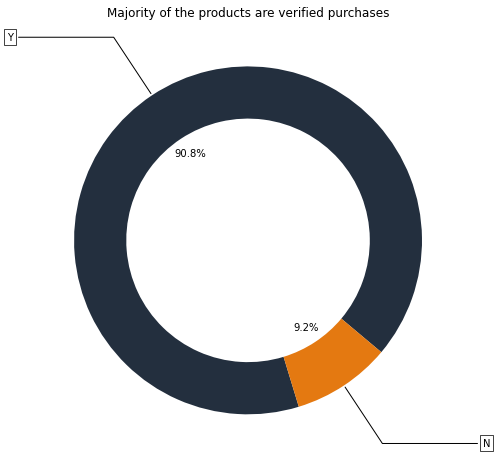

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
data = df.verified_purchase.value_counts()

wedges, texts, pct = ax.pie(data, wedgeprops=dict(width=0.3),
                            startangle=-40, autopct="%.1f%%")

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(data.index[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title('Majority of the products are verified purchases')

plt.show()

Out of all 330966, only 30370(9.2%) reviews are tagged as verified purchase. In the following sections, we are going to further examine these reviews to determine if they are paid or bot reviews.

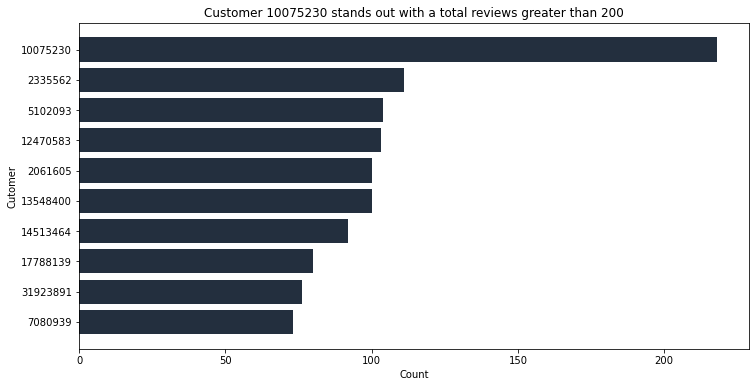

In [13]:
top10_cust = df.customer_id.value_counts().head(10)
top10_cust.sort_values(inplace=True)
plt.figure(figsize=(12, 6))

plt.barh([str(cust) for cust in top10_cust.index], top10_cust)
plt.ylabel('Cutomer')
plt.xlabel('Count')
plt.title('Customer 10075230 stands out with a total reviews greater than 200')
plt.show()

The plot above shows the number of reviews of the top 10 customers with the most reviews. Customer 10075230 stands out as the most active customer in the review section with 218 reviews in total. This customer will definitely will be a person of interest, suspected as a paid or a bot reviewer. Later in this report, we are going to the analyze the relationships of the customers using Network Analysis to see if these customers are connected.

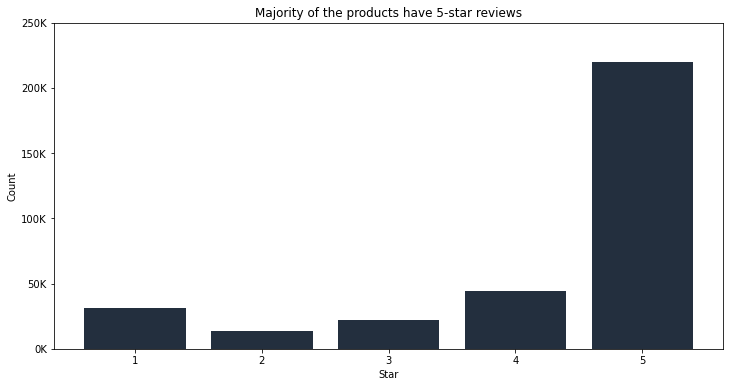

In [14]:
plt.figure(figsize=(12, 6))

plt.bar(df['star_rating'].value_counts().index,
          df['star_rating'].value_counts())
plt.ylabel('Count')
plt.xlabel('Star')
plt.title('Majority of the products have 5-star reviews')
ylabels = [f'{y/1000:.0f}K' for y in plt.gca().get_yticks()]

plt.gca().set_yticks(plt.gca().get_yticks())
plt.gca().set_yticklabels(ylabels)
plt.show()

Most of the reviews in the dataset have 5-star reviews. Either most of the products reviewed are excellent, customers are too lazy to accurately review the products, or these are fake reviews.

# Review Information Network

#### Get the top 500 customers with the highest number of reviews

In [483]:
top_idx = df.customer_id.value_counts().head(500).index

df_top = df.loc[df.customer_id.isin(top_idx)]

In [16]:
reviews = df_top.review_body.copy()
reviews_clean = reviews.apply(lambda x: text_cleaner(str(x)))

#### Remove Insignificant Words

In [17]:
exluclude_words = stop_words
exluclude_words.extend(['could', 'ok', 'simply', 'another',
                        'make', 'said', 'true', 'makes', 'almost',
                        'br', 'yet', 'thanks', 'also', 'gets', 'must',
                        'got', 'able', 'try', 'making', 'take', 'say',
                        'still', 'come', 'want', 'get', 'actually', 'instead',
                        'something', 'enough', 'put', 'keep', 'always',
                        'like', 'around', 'rather', 'anyone', 'wait'])
reviews_clean = reviews_clean.apply(lambda x: remove_words(x, 
                                                           exluclude_words))

#### Remove Low Frequency word

In [18]:
reviews_high_freq = reviews_clean.copy()

# Get word count of each word
word_count = Counter(chain.from_iterable(reviews_high_freq.tolist()))

# Check for word count less than 100
low_freq_words = {word for word, count in word_count.items() if count <= 200}

# Remove low freq words
reviews_high_freq = (reviews_high_freq
                     .apply(lambda x: remove_words(x, low_freq_words)))

#### Get co-occurence of words

In [19]:
words = set(chain.from_iterable(reviews_high_freq.tolist()))
word_cooccurrence = dict()
for word in tqdm(words):
    # Find cooccurence of words
    mask_word = reviews_high_freq.apply(lambda x: word in x)
    co_occurrence = Counter(chain.from_iterable(reviews_high_freq
                                               .loc[mask_word]
                                               .tolist()))
    # Delete own word
    del co_occurrence[word]
    
    # Store result
    word_cooccurrence[word] = co_occurrence

#### Create edges for the graph

In [20]:
edges = []
for nodei in tqdm(word_cooccurrence.keys()):
    for nodej, weight in word_cooccurrence[nodei].items():
        if ((nodei, nodej, weight) not in edges and
            (nodej, nodei, weight) not in edges):
            edges.append((nodei, nodej, weight))

In [21]:
df_words_edges = pd.DataFrame(edges, columns =['source', 'target', 'weight'])
df_words_edges.to_csv('words_edges_200.csv')
df_words_edges = pd.read_csv('words_edges_200.csv', index_col=0)

#### Construct Network Graph

In [99]:
review_G = nx.from_pandas_edgelist(df_words_edges, source='source',
                                       target='target', edge_attr='weight')
review_G_prop = NetworkProperties(review_G)
print(review_G_prop)

Network Properties:
N = 241
L = 28848
avg_degree = 119.70124481327801
max_degree = 240
min_degree = 218
density = 0.4987551867219917
avg_shortest_path = 1.0024896265560166
avg_clustering_coeff = 0.9976584561635381
shortest_path_length_max = 2.0
shortest_path_length_max_edge = ('comes', 'pokemon')
is_connected = True
maximal_cliques = 233


In [100]:
lm = LouvainMethod()
lm_result = lm.fit_transform(review_G)

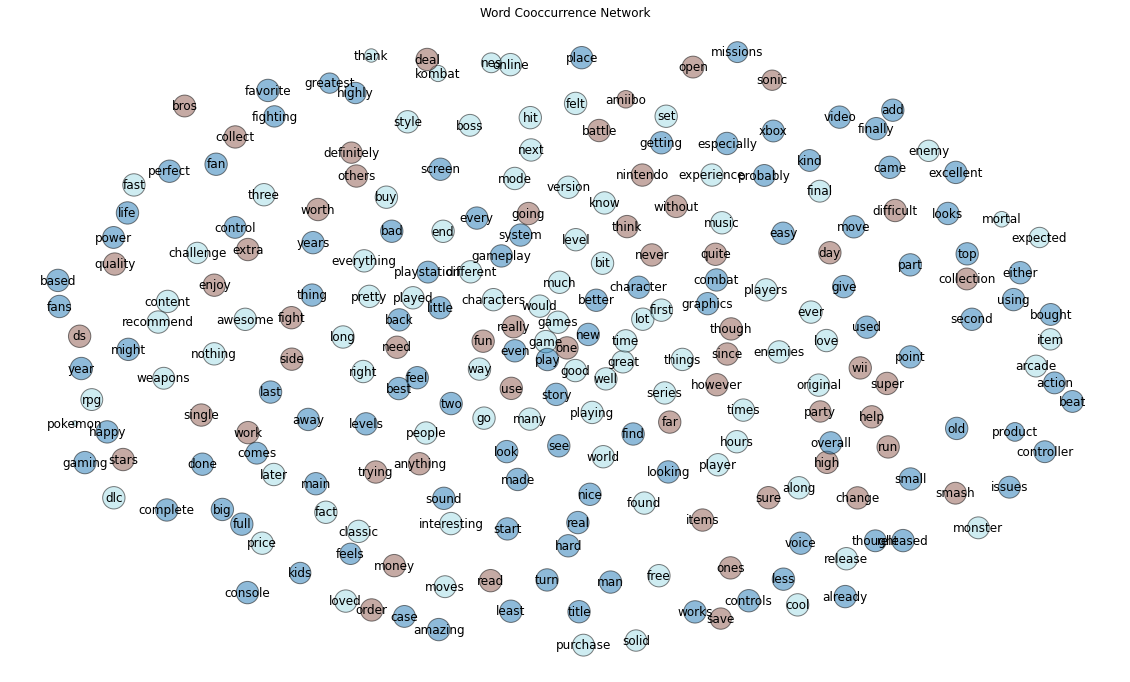

In [274]:
fig, ax = plt.subplots(figsize=(20, 12));
pos = nx.fruchterman_reingold_layout(review_G, k=13, seed=11)
node_size = NodeSizeScaler(
    min_size=30, max_size=500).fit_transform(review_G)

nx.draw_networkx_nodes(review_G, pos, node_size=node_size, cmap='tab20',
                       alpha=0.5,
                       node_color=lm_result,
                       edgecolors='black', ax=ax)
nx.draw_networkx_labels(review_G, pos, ax=ax)
ax.axis('off');
ax.set_title('Word Cooccurrence Network');
plt.show();

# FIM

customer1: {product1, product2, product3},

customer2: {product1, product2, product4}

## Confidence, Lift, Covariance

# Customer Network

In [60]:
df_cust = (df_top.groupby(['customer_id'])['product_id']
           .apply(set).to_frame().reset_index())
df_cust['count_prod'] = df_cust.product_id.apply(len)
df_cust.product_id = df_cust.product_id.apply(list)

#### Construct Bi-Partite Graph

In [64]:
bi_partite_G = nx.Graph()
customers = df_cust.customer_id.tolist()
products = df_cust.product_id.tolist()

In [65]:
for idx, cust in enumerate(customers):
    bi_partite_G.add_node(cust, bipartite=0)
    for prod in products[idx]:
        bi_partite_G.add_node(prod, bipartite=1)
        bi_partite_G.add_edge(cust, prod)

#### Construct Customer Network

In [298]:
edge_weights = {}
to_remove = []
customer_G = bi_partite_G.copy()
for node in customer_G.nodes(data=True):
    if node[1]['bipartite'] == 1:
        # Remove product nodes
        to_remove.append(node[0])
        neighbours = list(customer_G.neighbors(node[0]))
        for i in range(len(neighbours) - 1):
            for j in range(i+1, len(neighbours)):
                edge = tuple(set((neighbours[i], neighbours[j])))
                if edge in edge_weights:
                    edge_weights[edge]['weight'] += 1
                else:
                    edge_weights[edge] = {'weight' : 1}
                customer_G.add_edge(*edge)

customer_G.remove_nodes_from(to_remove)
nx.set_edge_attributes(customer_G, edge_weights)

In [119]:
isolates = list(nx.isolates(customer_G))
labels = {node: node for node in customer_G.nodes() if node in isolates}

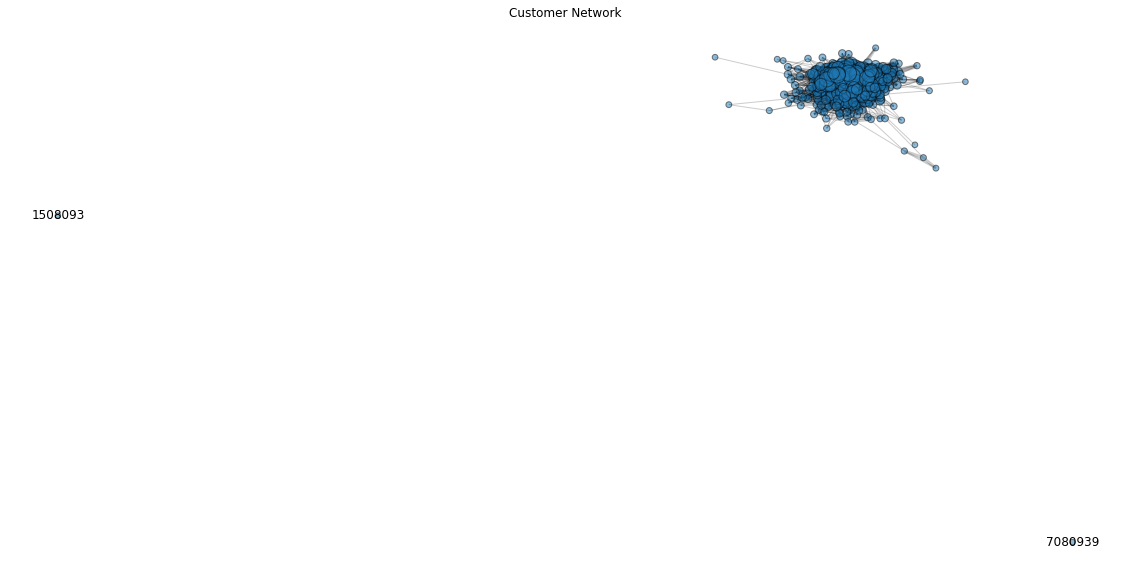

In [322]:
edgelist = [(edge[0], edge[1]) for edge in customer_G.edges(data=True)]
edgewidth = [edge[2]['weight'] for edge in customer_G.edges(data=True)]

fig, ax = plt.subplots(figsize=(20, 10))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=30, max_size=500).fit_transform(customer_G)

pos = nx.spring_layout(customer_G, seed=11)
nx.draw_networkx_nodes(customer_G, pos, node_size=node_size,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)
nx.draw_networkx_labels(customer_G, pos, labels)
plt.title('Customer Network')
plt.show()

The two unconnected nodes (customers) with high product reviews are observed to have given "5 star ratings" on all their reviews and both have unverified purchases and suspiciously acting as a bot. Customer `1508093` only has common review text statements while customer `7080939`'s review text are based on the `product_title`

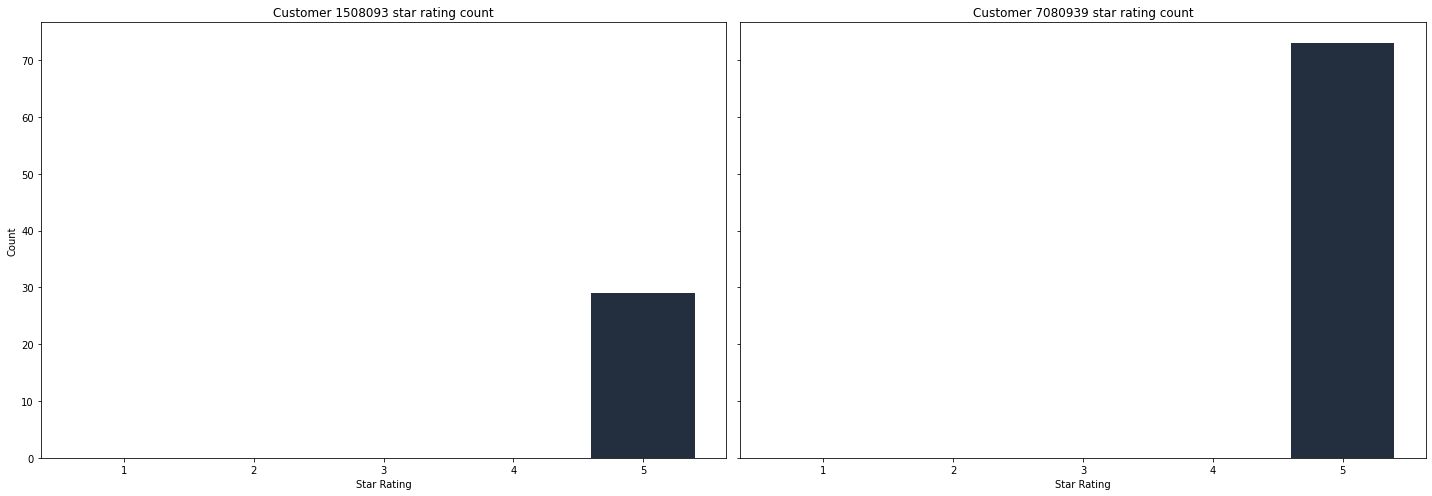

In [143]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

x = range(1, 6)
iso_val_count = df.loc[df.customer_id ==
                       1508093].star_rating.value_counts().to_dict()
iso_val_count = [iso_val_count[star] if star in iso_val_count else 0
                 for star in x]
ax[0].bar(x, iso_val_count)
ax[0].set_title(f'Customer 1508093 star rating count')
ax[0].set_xlabel('Star Rating')
ax[0].set_ylabel('Count')


iso_val_count = df.loc[df.customer_id ==
                       7080939].star_rating.value_counts().to_dict()
iso_val_count = [iso_val_count[star] if star in iso_val_count else 0
                 for star in x]
ax[1].bar(x, iso_val_count)
ax[1].set_title(f'Customer 7080939 star rating count')
ax[1].set_xlabel('Star Rating')

plt.tight_layout();

In [232]:
df.loc[df.customer_id == 1508093, ['product_title', 'review_body']].sample(8)

,product_title,review_body
73378,Joker Batman Skin Sticker Decal for PS4 Console,excellent
74065,Star Wars Skins for PS4 Console,excellent
74146,Skins for PS4 Console Decal,excellent
73645,Designer XBOX One Vinyl Skin Kill Zone Shadow ...,excellent
73343,Ducati Decal Skin Cover Sticker for Ps4 Consol...,excellent
74072,Super Mario Bros Game Decal Skin Stickers for ...,excellent
73395,Protective Vinyl Decal Skin Sticker for Ps4 Co...,excellent
73502,decal Skins sticker for PS4 Console,excellent


In [233]:
df.loc[df.customer_id == 7080939, ['product_title', 'review_body']].sample(8)

,product_title,review_body
128563,Just Dance Kids 2014 Wii,just dance kids 2014
128489,JUST DANCE KIDS,just dance kids 1
128665,Just Dance Kids Wii (17634) -,just dance kids 1
129183,WII JUST DANCE DISNEY PARTY,just dance disney
131806,Sesame Street Search & Learn Adventures,search learn adventures cd rom
128036,Just Dance Kids 2014 Wiiu,just dance kids 2014
129228,Just Dance Disney Party E Rated for Everyone,just dance disney
129091,WII JUST DANCE GREATEST HITS,just dance greatest hits


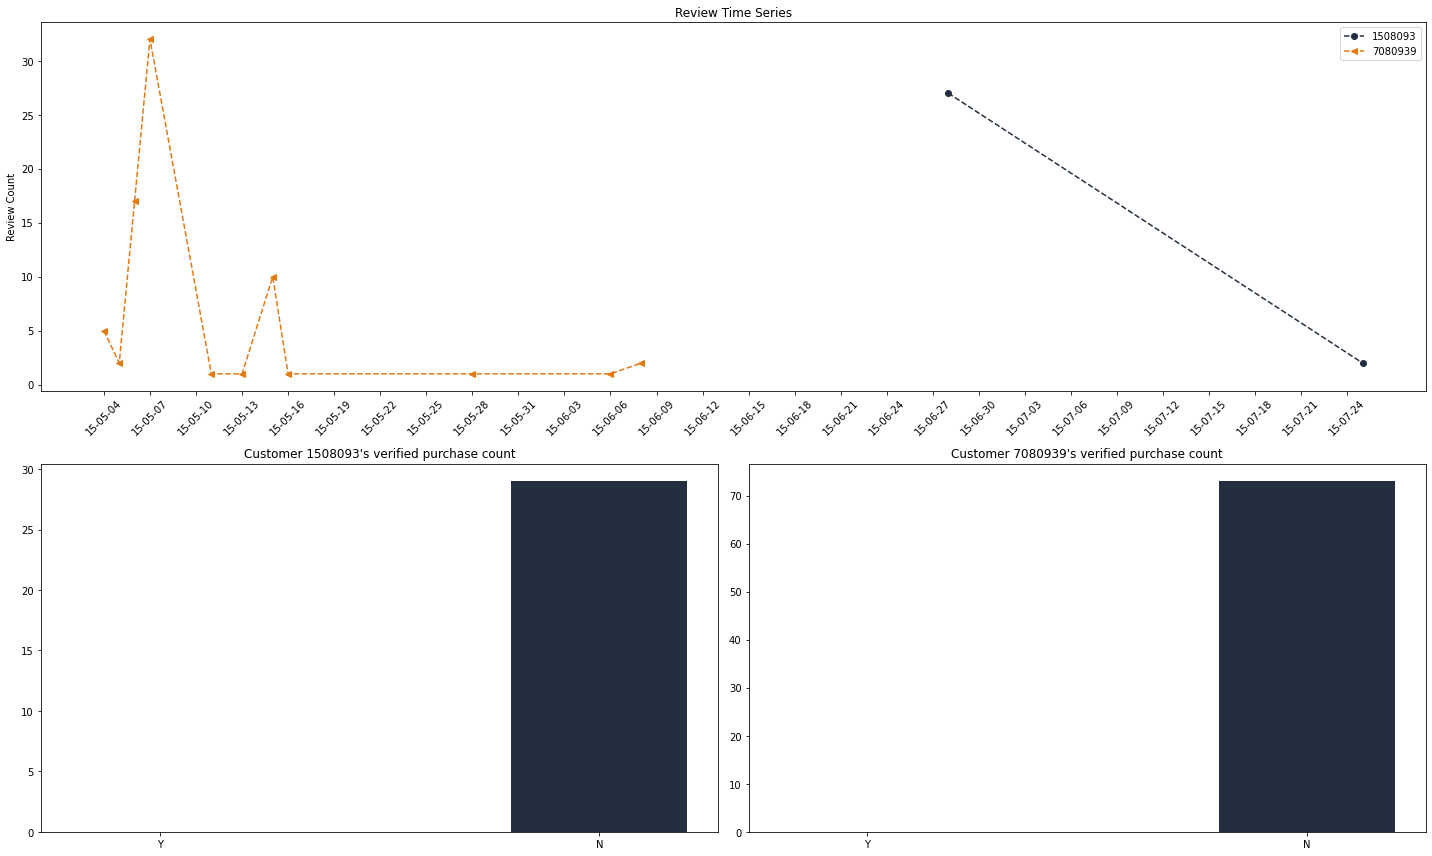

In [263]:
df_ts1 = df.loc[df.customer_id == 1508093,
                ['product_id', 'review_date', 'verified_purchase']].copy()
df_ts1.review_date = pd.to_datetime(df_ts1.review_date)

df_ts2 = df.loc[df.customer_id == 7080939,
                ['product_id', 'review_date', 'verified_purchase']].copy()
df_ts2.review_date = pd.to_datetime(df_ts2.review_date)

ts1 = df_ts1.groupby('review_date')['product_id'].apply(len)
ts2 = df_ts2.groupby('review_date')['product_id'].apply(len)

fig = plt.figure(figsize=(20, 12))

gs = GridSpec(2, 2, figure=fig)

ax0 = fig.add_subplot(gs[0, :])

ax0.plot(ts1, 'o--')
ax0.plot(ts2, '<--')
ax0.legend([1508093, 7080939])

date_range = ts1.append(ts2).sort_index().index
date_range = pd.date_range(start=date_range[0], end=date_range[-1],
                           freq='D')[::3]
date_labels = [x.strftime('%y-%m-%d') for x in date_range]
ax0.set_xticks(date_range)
ax0.set_xticklabels(date_labels, rotation=45)
ax0.set_title('Review Time Series')
ax0.set_ylabel('Review Count')

x = ['Y', 'N']
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

verif_val_count = df_ts1.verified_purchase.value_counts().to_dict()
verif_val_count = [verif_val_count[val] if val in verif_val_count else 0
                   for val in x]
ax1.bar(x, verif_val_count, width=0.4)
ax1.set_title('Customer 1508093\'s verified purchase count')


verif_val_count = df_ts2.verified_purchase.value_counts().to_dict()
verif_val_count = [verif_val_count[val] if val in verif_val_count else 0
                   for val in x]
ax2.bar(x, verif_val_count, width=0.4)
ax2.set_title('Customer 7080939\'s verified purchase count')

fig.tight_layout()

del df_ts1, df_ts2  # , ts1, ts2

#### Analyze Giant Component

In [325]:
customer_giant_G = customer_G.subgraph(
    max(nx.connected_components(customer_G), key=len))

Network Properties:
N = 498
L = 13013
avg_degree = 26.130522088353413
max_degree = 212
min_degree = 1
density = 0.05257650319588212
avg_shortest_path = 2.1063246951589054
avg_clustering_coeff = 0.35318156974915754
shortest_path_length_max = 6.0
shortest_path_length_max_edge = (36149340, 41367567)
is_connected = True
maximal_cliques = 25


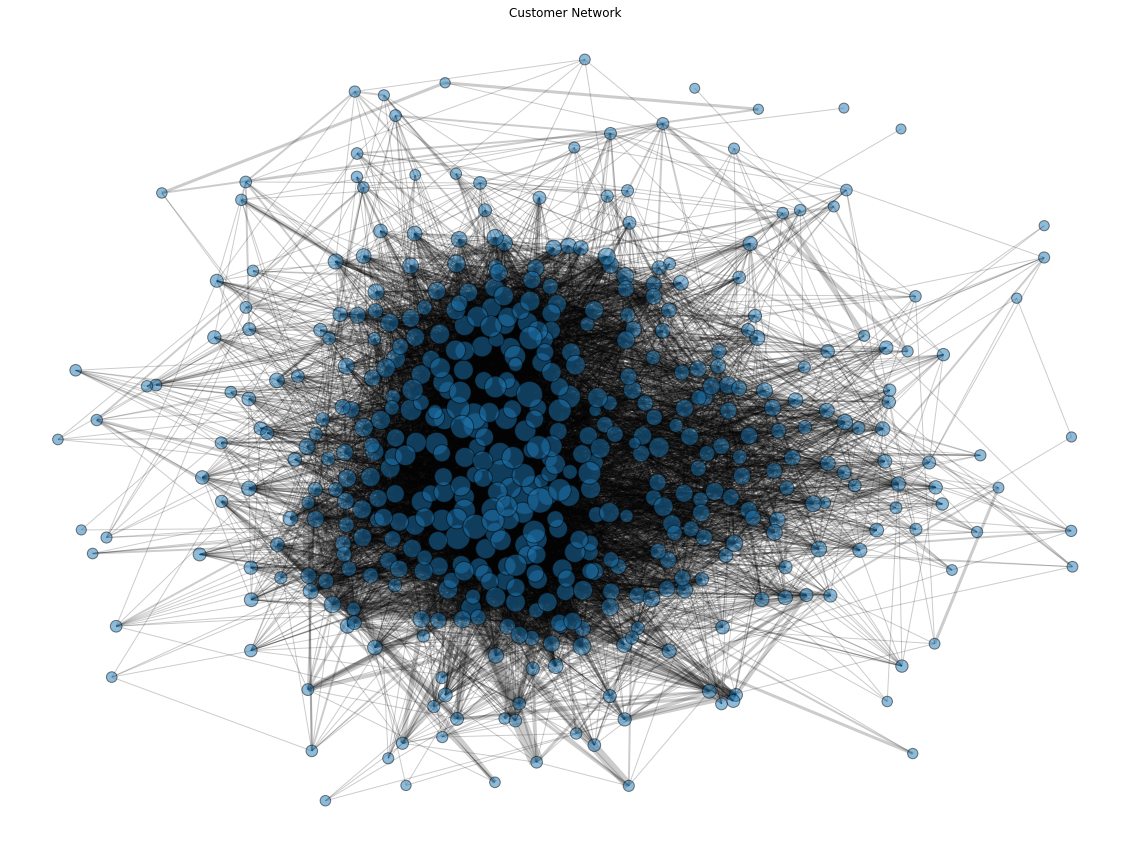

In [383]:
edgelist = [(edge[0], edge[1]) for edge in customer_giant_G.edges(data=True)]
edgewidth = [edge[2]['weight'] for edge in customer_giant_G.edges(data=True)]

fig, ax = plt.subplots(figsize=(20, 15))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=100, max_size=800).fit_transform(customer_giant_G)

pos = nx.fruchterman_reingold_layout(customer_giant_G, k=0.7, seed=11)
# pos = nx.fruchterman_reingold_layout(customer_giant_G, k=1.5, seed=11)
nx.draw_networkx_nodes(customer_giant_G, pos, node_size=node_size,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_giant_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)

print(nxa.NetworkProperties(customer_giant_G))
plt.title('Customer Network')
plt.show()

In [334]:
lm = LouvainMethod()
lm_result = lm.fit_transform(customer_giant_G)

6 communities


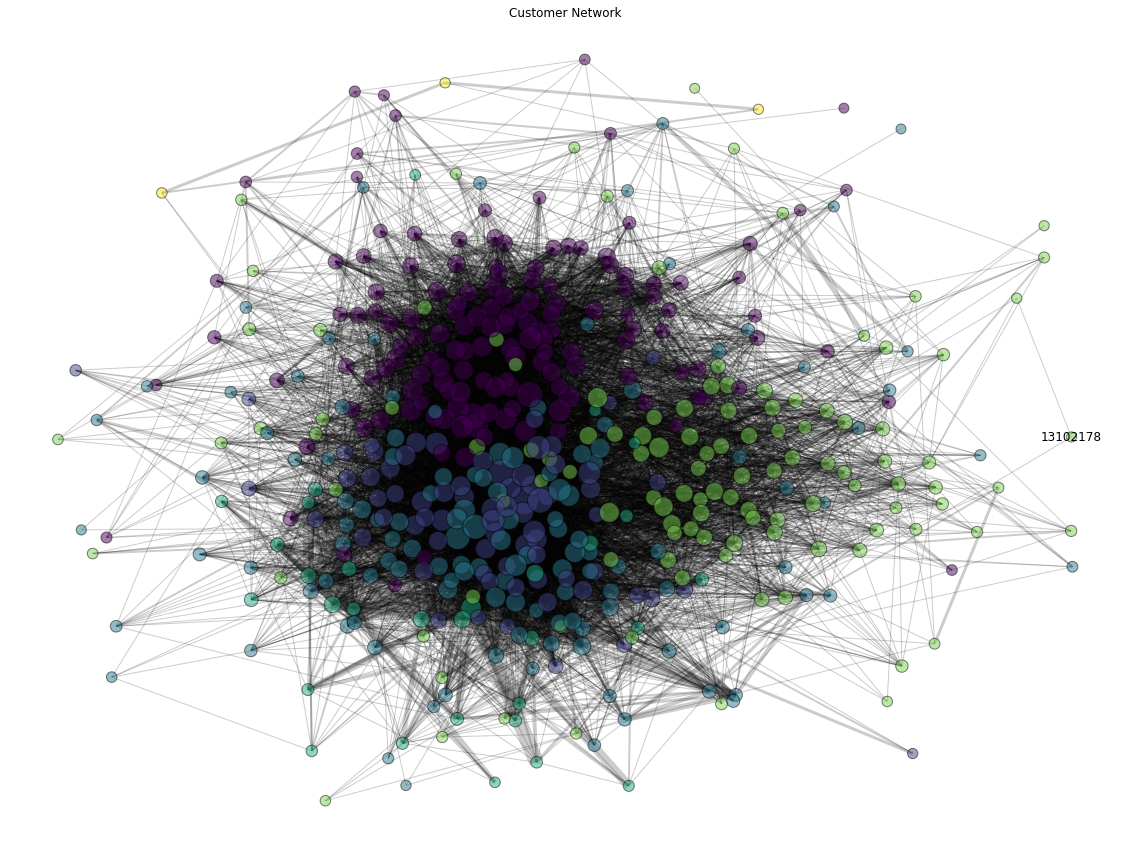

In [489]:
fig, ax = plt.subplots(figsize=(20, 15))
ax.axis("off")

node_size = NodeSizeScaler(
    min_size=100, max_size=800).fit_transform(customer_giant_G)

pos = nx.fruchterman_reingold_layout(customer_giant_G, k=0.7, seed=11)
nx.draw_networkx_nodes(customer_giant_G, pos, node_size=node_size,
                       node_color=lm_result,
                       alpha=0.5,
                       edgecolors='black',
                       ax=ax)
nx.draw_networkx_edges(customer_giant_G, pos, edgelist=edgelist,
                       width=edgewidth, alpha=0.2, ax=ax)

nx.draw_networkx_labels(customer_G, pos, {13102178: '13102178'})

print(f'{len(set(lm_result))} communities')
plt.title('Customer Network')
plt.show()

In [471]:
# Nodes with the lowest degree
lowest_cust_degree = [customer for customer, degree in customer_giant_G.degree
                      if degree <= 10]
df_lowest_degree = df.loc[df.customer_id.isin(lowest_cust_degree)].copy()

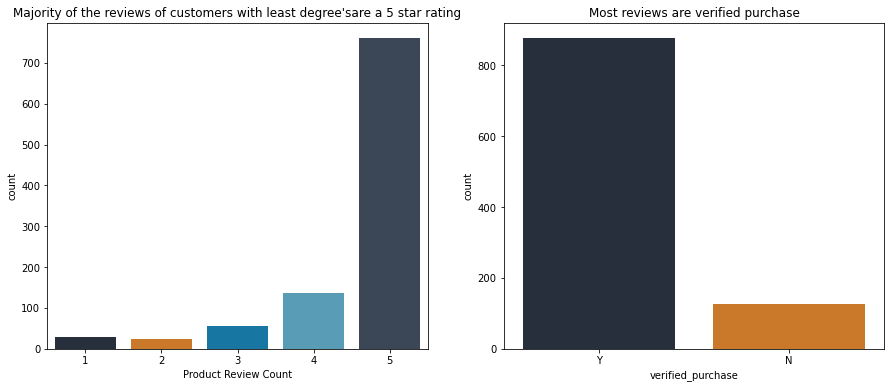

In [472]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.countplot(x='star_rating', data=df_lowest_degree, ax=ax[0])
ax[0].set_title(f'Majority of the reviews of customers with least degree\'s'
                'are a 5 star rating')
ax[0].set_xlabel('Product Review Count')

sns.countplot(x='verified_purchase', data=df_lowest_degree, ax=ax[1])
ax[1].set_title('Most reviews are verified purchase')
plt.show()

In [486]:
top5_high_raters = df_lowest_degree.loc[df_lowest_degree.star_rating == 5,
                                        'customer_id'].value_counts().iloc[:5]
df_ts = df_lowest_degree.loc[df_lowest_degree
                             .customer_id.isin(top5_high_raters.index)]

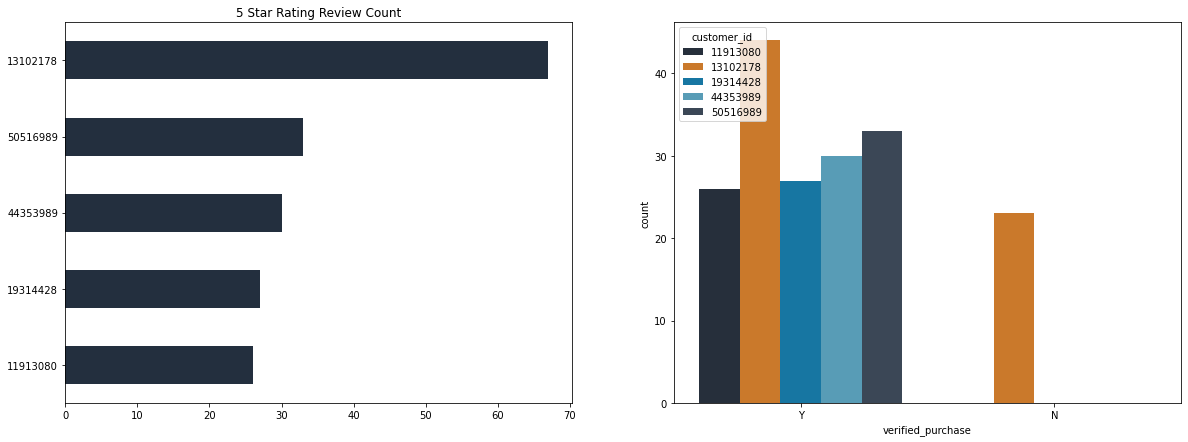

In [487]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
top5_high_raters.sort_values(ascending=True).plot.barh(ax=ax[0])
ax[0].set_title('Customer 13102178 has given 5 star reviews 67 products')
ax[0].set_title('5 Star Rating Review Count')

sns.countplot(x='verified_purchase', data=df_ts, hue='customer_id');

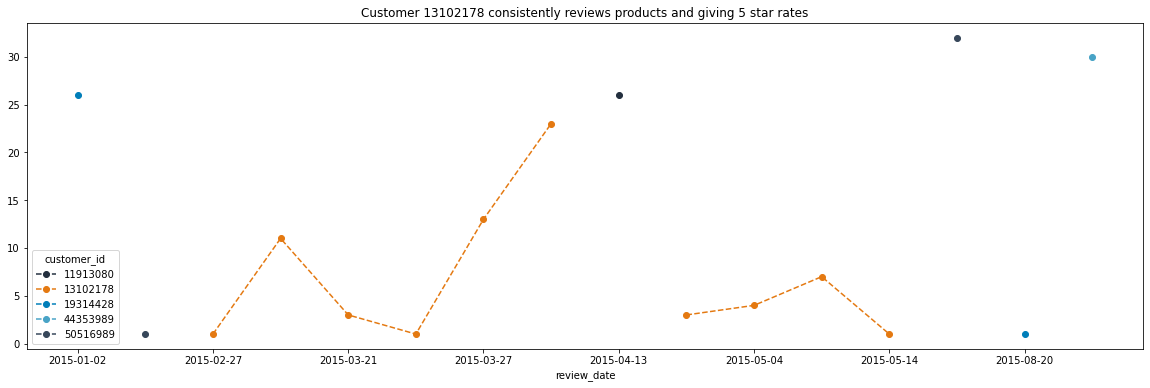

In [475]:

df_ts = (df_ts.groupby(['customer_id', 'review_date'])
         .product_id.apply(len).to_frame().reset_index())
df_ts.rename(columns=dict(product_id='product_count'), inplace=True)
df_ts.sort_values(by='review_date', inplace=True)

date_range = pd.date_range(start=df_ts.review_date.iloc[0],
                           periods=df_ts.shape[0], freq='D')
date_labels = [x.strftime('%y-%m-%d') for x in date_range]

df_ts = df_ts.pivot(index='review_date', values='product_count',
                    columns='customer_id')

fig, ax = plt.subplots(figsize=(20, 6))
df_ts.plot(marker='o', linestyle='--', ax=ax)
ax.set_title('Customer 13102178 consistently reviews products and '
             'giving 5 star rates');
# ax.set_ylim((-2, 33))

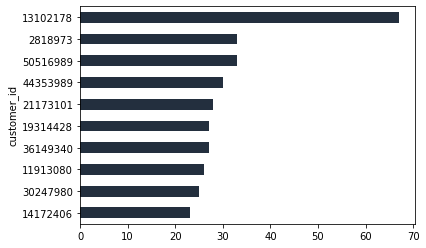

In [476]:
df_lowest_degree.groupby('customer_id').apply(len).sort_values().iloc[-10:].plot.barh();

In [477]:
customer_giant_G.degree(13102178)

2

<AxesSubplot:>

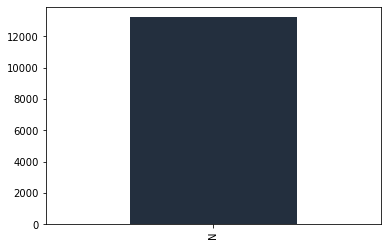

In [484]:
df_top.vine.value_counts().plot.bar()

In [492]:
df_lowest_degree.loc[df_lowest_degree.customer_id==13102178, ['vine', 'review_headline', 'review_body']]

,vine,review_headline,review_body
121131,N,good,Good
122494,N,Good,Good
122617,N,Good,Good
122937,N,Good,Good
123054,N,Good,Good
...,...,...,...
207735,N,Five Stars,Good
208442,N,Five Stars,Good
208531,N,Five Stars,Good
208696,N,Five Stars,Good


In [495]:
df.loc[df.customer_id==9877201, ['vine', 'review_headline', 'review_body']]

,vine,review_headline,review_body
94753,N,Awesome Game,Really enjoyed this game. I have waited years ...
94777,N,Nice,Missed this classic on this awesome system.
95133,N,Nice Find,I missed this classic game. This was my first ...
95476,N,Good Game,I forgot how frantic the action was in this ar...
96580,N,Very Happy,Takes 2 AAA batteries and works like a charm. ...
97177,N,thanks!,Items work as described
97356,N,good find,Glad to have these just need to format them to...
105477,N,Yes!,I've played the PS version for years. Getting ...
106094,N,Very Cool Game,Was really excited to pick up this title after...
106513,N,Enjoying This One for a Second Time,I gave the N64 version of this classic wrestli...


In [491]:
list(customer_giant_G.neighbors(13102178))

[1428221, 9877201]

Investigate per Cluster

    * Distribution of star rating and helpful votes per cluster
    * Check verified purchase per cluster
    

Investigate least degree/centrality nodes (star rating)
    
    * pag yung star rating puro mataas, suspicious
    * pag review halos hindi pinag isipan, suspicious
    * pag ikaw lang bumili, tapos puro 5 star pa yung review mo
    * verified purchase

Investigate highest degree/centrality nodes (sentiment analysis)

    * distribution of star rating

nodes with the least edge = least common reviewed products
nodes with the highest edge = most common reviewed products = 



## Construct the Network

Color code based on 5 rating, scale the size of the node based on number of degrees, change the weight of the links based on prevalence of reviewed products.

## Network Properties

## Centrality Measurements

## Community Detection

# Conclusion

# Recommendation

# Reference